# Pipeline test with RCA FISH

- Inputs:
    - 1 RCA FISH sample image
    - expert annotations of the sample image
    - 3 RCA FISH test images
- Operations: 
    - **Part 1**: parameter extraction from sample image
    - **Part 2**: blob detection on test images, using parameter extraction
    - **Part 3**: recursive cropping of test images, using parameter extraction
- Outputs:
    - recursive crops ready to be sent to mechanical turkers

In [1]:
from math import floor, sqrt
from scipy import ndimage, optimize
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.neighbors import KDTree
from numpy import pi, r_
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import math, random, sys, os
sys.path.insert(0, '../../../FISH-annotation/Annotation')
import util

## User-determined parameters

In [2]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 4
max_num_crops = 7
colors = ['red', 'orange', 'black', 'green', 'blue', 'purple', 'cyan']

# Part 1: Parameter Extraction

### This section of the pipeline:

- Inputs:
    - sample FISH image
    - expert annotations of the image
- Outputs: 
    - parameters specific to RCA FISH for blob detection
        - max sigma: `sigma_max`
        - optimal intensity threshold: `best_threshold`

### Metadata for sample image

In [3]:
sample_img_filename = 'RCA.png'
sample_img_path = os.getcwd() + '/sample_image/' + sample_img_filename

sample_coords_filename = 'rca.csv'
sample_coords_path = os.getcwd() + '/sample_image/' + sample_coords_filename

### View sample image

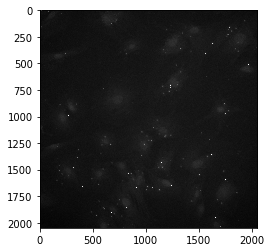

In [4]:
im = imread(sample_img_path)
im_gray = rgb2gray(im)
plt.imshow(im_gray, cmap='gray')
plt.show()

### Read in the image and the expert annotations

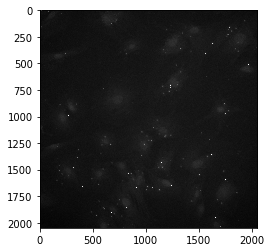

../../../FISH-annotation/Annotation/util.py:199: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()


In [5]:
im = imread(sample_img_path)
im = rgb2gray(im)
img_height = len(im)
plt.imshow(im, cmap='gray')
plt.show()

ref_coords = np.genfromtxt(sample_coords_path, delimiter=',')[1:]
ref_kdt = util.csv_to_kdt(sample_coords_path, img_height)

# Find the sigma_max (the greatest spot size)

### Gaussian fit methods
Cell below from https://scipy-cookbook.readthedocs.io/items/FittingData.html.

In [6]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

### Find the size of each spot identified by the expert and take the max

In [7]:
sigma_max_list = []
for x, y in ref_coords:

    x_min = int(x)-margin if int(x)-margin >= 0 else 0
    x_max = int(x)+margin if int(x)+margin < im.shape[1] else im.shape[1]-1
    y_min = int(y)-margin if int(y)-margin >= 0 else 0
    y_max = int(y)+margin if int(y)+margin < im.shape[0] else im.shape[0]-1

    crop = im[y_min:y_max, x_min:x_max]
    params = fitgaussian(crop)
    fit = gaussian(*params)
    (height, x_param, y_param, width_x, width_y) = params
    sigma_max = math.sqrt(max(width_x, width_y)/2)
    sigma_max_list.append(sigma_max)
max_sigma = max(sigma_max_list)

/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


In [8]:
print('greatest spot_sigma = %f' % (sigma_max))

greatest spot_sigma = 1.421396


# Find the optimal intensity threshold

### Assign a range of intensity thresholds to test.

In [9]:
thresholds = np.arange(0.02, 0.10, 0.01)

### Run blob detection with a range of thresholds and evaluate precision and recall overall.

In [10]:
best_precision_x_recall = 0
precision_list = []
recall_list = []
for threshold in thresholds:
    
    print('Threshold = %f' % round(threshold, 2))
    
    blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=threshold)
    blobs = []
    for r, c, sigma in blobs_log:
        blobs.append([c, r])
    blobs_kdt = KDTree(blobs, leaf_size=2, metric='euclidean')	# kdt is a kd tree with all the reference points

    num_blobs_total = len(blobs_log)
    num_ref_total = len(ref_coords)

    correct_blobs = []
    incorrect_blobs = []
    detected_ref = []
    undetected_ref = []

    # correct vs. incorrect

    for r, c, sigma in blobs_log:
        dist, ind = ref_kdt.query([[c, img_height-r]], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blobs.append((r, c, sigma))
        else:
            incorrect_blobs.append((r, c, sigma))

    # detected vs. undetected

    for x, y in ref_coords:
        dist, ind = blobs_kdt.query([[x, y]], k=1)
        if dist[0][0] < correctness_threshold:
            detected_ref.append([x, y])
        else:
            undetected_ref.append([x, y])

    # calculate precision and recall and see if this is the best precision_x_recall we've found yet

    precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
    recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
    if (precision * recall) > best_precision_x_recall:
        best_precision_x_recall = precision * recall
        best_precision = precision
        best_recall = recall
        best_threshold = threshold
    precision_list.append(precision)
    recall_list.append(recall)

Threshold = 0.020000
Threshold = 0.030000
Threshold = 0.040000
Threshold = 0.050000
Threshold = 0.060000
Threshold = 0.070000
Threshold = 0.080000
Threshold = 0.090000


Text(0.5,1,'Precision-Recall, intensity threshold = np.arange(0.02, 0.18, 0.01)')

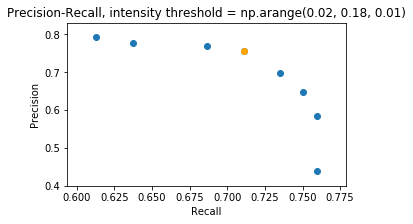

In [11]:
plt.figure(figsize = (5, 3))
plt.scatter(recall_list, precision_list)
plt.scatter([best_recall], [best_precision], c='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall, intensity threshold = np.arange(0.02, 0.18, 0.01)')

In [12]:
print('optimal intensity threshold = %f' % (round(best_threshold, 2)))

optimal intensity threshold = 0.060000


### The max sigma and optimal intensity threshold found above with parameter extraction are now considered "tuned" parameters. 
If we are satisfied with them, we can use them with blob_log() on other smFISH chemistries.

In [13]:
print('greatest spot_sigma = %f' % (round(sigma_max, 2)))
print('optimal intensity threshold = %f' % (round(best_threshold, 2)))

greatest spot_sigma = 1.420000
optimal intensity threshold = 0.060000


# Part 2: Blob Detection

### This section of the pipeline:

- Inputs:
    - parameters specific to RCA FISH for blob detection
        - max sigma: `sigma_max`
        - optimal intensity threshold: `best_threshold`
- Outputs:
    - coordinates of spots detected by blob detection: `blobs` (in `blobs_list`)

### Paths to test images and coords

In [14]:
test_img_filenames = ['ISS_rnd0_ch1_z0', 'ISS_rnd0_ch3_z0', 'ISS_rnd1_ch1_z0']
test_img_paths = [os.getcwd() + '/test_images/images/%s.png' % x for x in test_img_filenames]
test_coords_paths = [os.getcwd() + '/test_images/coords/%s.csv' % x for x in test_img_filenames]


### View sample images

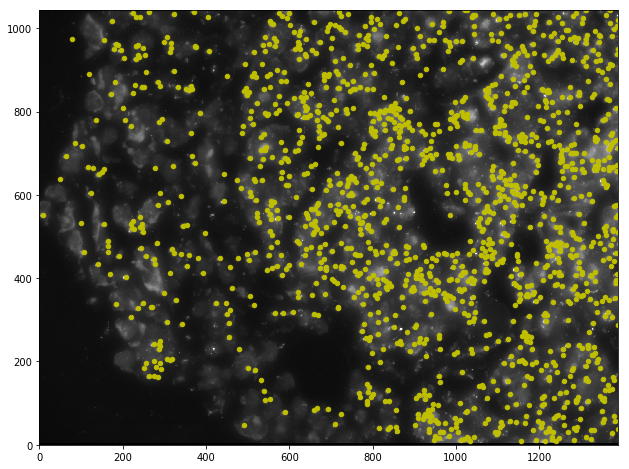

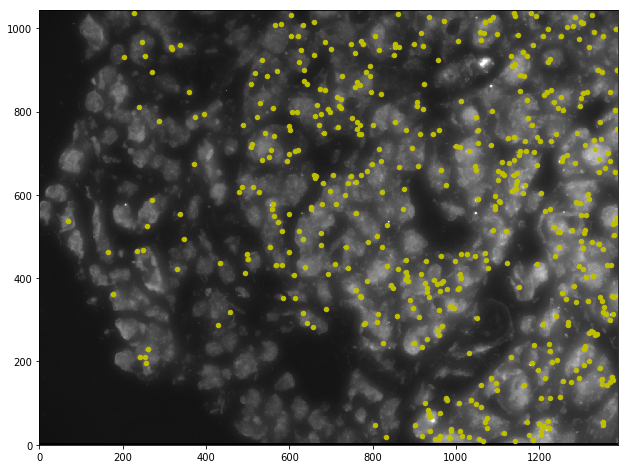

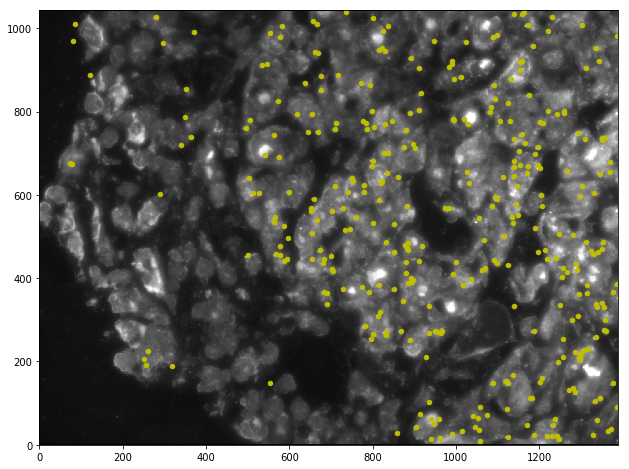

In [15]:
for img_path, coords_path in zip(test_img_paths, test_coords_paths):
    im = imread(img_path)
    im_gray = rgb2gray(im)
    plt.figure(figsize=(12, 8))
    plt.imshow(im_gray, cmap='gray')
    # show ref coords for test images
    ref_coords = np.genfromtxt(coords_path, delimiter=',')
    for x, y in ref_coords[1:]:
        plt.scatter([x], [y], s=20, c='y')
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.show()

### Run blob_log() on all test images using sigma_max and best_threshold found above.

In [16]:
precision_list = []
recall_list = []
sort_list = []
blobs_list = []

# For each test image
for img_path, coords_path in zip(test_img_paths, test_coords_paths):
    im = imread(img_path)
    im_gray = rgb2gray(im)
    img_height = len(im)  
    ref_coords = np.genfromtxt(coords_path, delimiter=',')
    ref_kdt = util.csv_to_kdt(coords_path, img_height)
    
    blobs_log = blob_log(im, max_sigma=sigma_max, num_sigma=10, threshold=best_threshold)
    blobs = [[c, r] for r, c, sigma in blobs_log]
    blobs_list.append(blobs)
    blobs_kdt = KDTree(blobs, leaf_size=2, metric='euclidean')
    
    num_blobs_total = len(blobs_log)
    num_ref_total = len(ref_coords)
    
    correct_blobs = []
    incorrect_blobs = []
    detected_ref = []
    undetected_ref = []
    
    # correct vs. incorrect
    
    for r, c, sigma in blobs_log:
        dist, ind = ref_kdt.query([[c, img_height-r]], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blobs.append((r, c, sigma))
        else:
            incorrect_blobs.append((r, c, sigma))
    
    # detected vs. undetected
    
    for x, y in ref_coords[1:]:
        dist, ind = blobs_kdt.query([[x, y]], k=1)
        if dist[0][0] < correctness_threshold:
            detected_ref.append([x, y])
        else:
            undetected_ref.append([x, y])
    
    sort_list.append((correct_blobs, incorrect_blobs, detected_ref, undetected_ref))
    
    # calculate precision and recall
    
    precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
    recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
    
    precision_list.append(precision)
    recall_list.append(recall)

### Plot Correct vs. Incorrect, Detected vs. Undetected

Intensity threshold = 0.060000


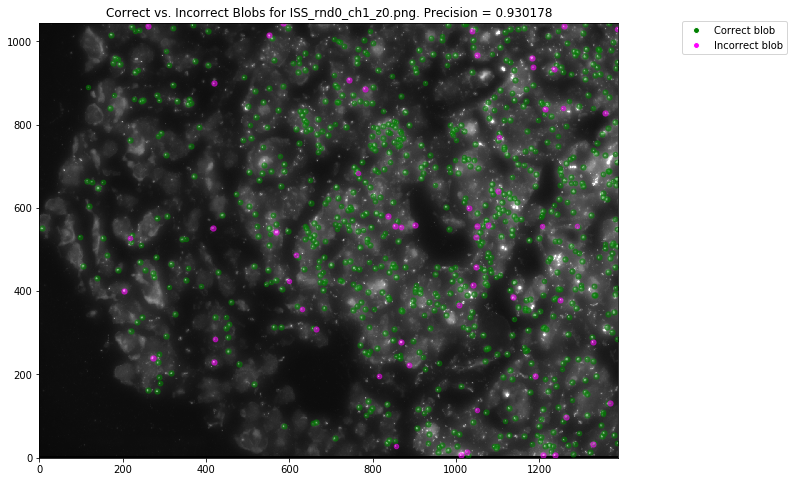

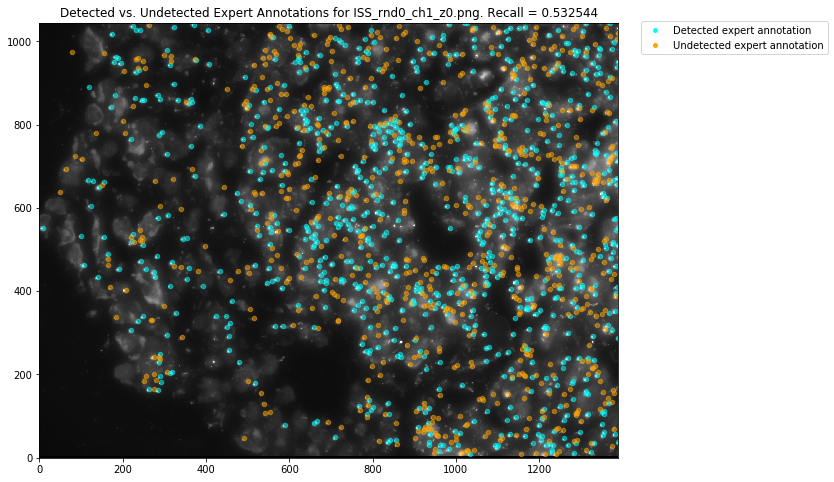

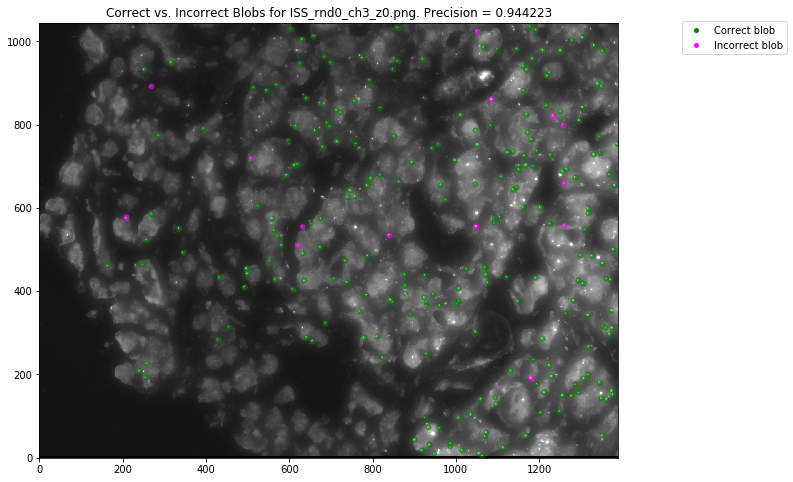

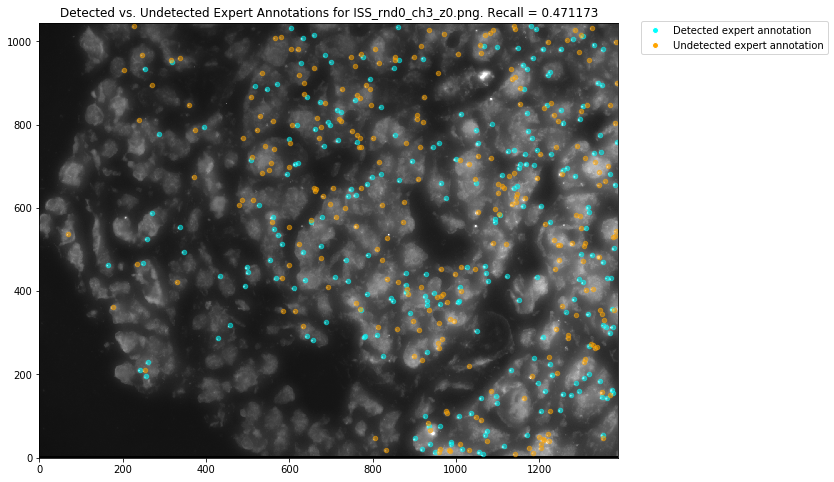

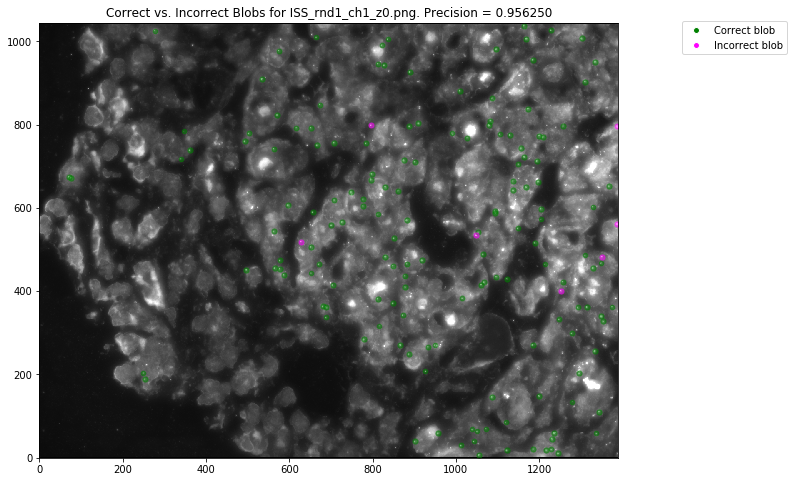

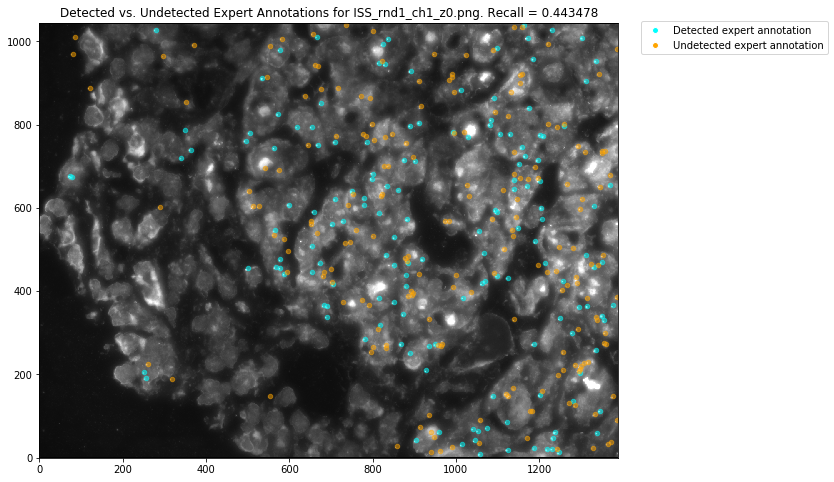

In [17]:
print('Intensity threshold = %f' % best_threshold)
    
for sort, img_name, img_path, precision, recall in zip(sort_list, test_img_filenames, test_img_paths, precision_list, recall_list):
    
    correct_blobs, incorrect_blobs, detected_ref, undetected_ref = sort
    im = imread(img_path)
    im_gray = rgb2gray(im)
    
    # plot correct vs. incorrect

    plt.figure(figsize=(12, 8))
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.imshow(im_gray, cmap='gray')
    for r, c, sigma in correct_blobs:
        plt.scatter([c], [r], alpha=0.5, s=int(sigma*20), c='green')
    for r, c, sigma in incorrect_blobs:
        plt.scatter([c], [r], alpha=0.5, s=int(sigma*20), c='magenta')

    handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='green', label='Correct blob'),
                  Line2D([0],[0], marker='o', color='w', markerfacecolor='magenta', label='Incorrect blob')]
    plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.2, 1.015))
    plt.title('Correct vs. Incorrect Blobs for %s.png. Precision = %f' % (img_name, precision))
    plt.show()
    
    # plot detected vs. undetected

    plt.figure(figsize=(12, 8))
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.imshow(im_gray, cmap='gray')
    for x, y in detected_ref:
        plt.scatter([x], [y], alpha=0.5, s=20, c='cyan')
    for x, y in undetected_ref:
        plt.scatter([x], [y], alpha=0.5, s=20, c='orange')
    handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='cyan', label='Detected expert annotation'),
                  Line2D([0],[0], marker='o', color='w', markerfacecolor='orange', label='Undetected expert annotation')]
    plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.2, 1.015))	
    plt.title('Detected vs. Undetected Expert Annotations for %s.png. Recall = %f' % (img_name, recall))
    plt.show()
    

# Part 3: Recursive Cropping

### This section of the pipeline:

- Inputs:
    - coordinates of spots detected by blob detection: `blobs` (in `blobs_list`)
- Outputs:
    - recursive crops ready to be sent to mechanical turkers

In [18]:
def get_nnd(coord, kdt):
    dist, ind = kdt.query([coord], k=2)
    return dist[0][1]

crosshair_arm_to_image_width_ratio = 0.03045   # measured empirically in Quantius's UI

## Step 1: ID crowded spots

crowded blobs / total blobs = 814 / 845 = 0.963314


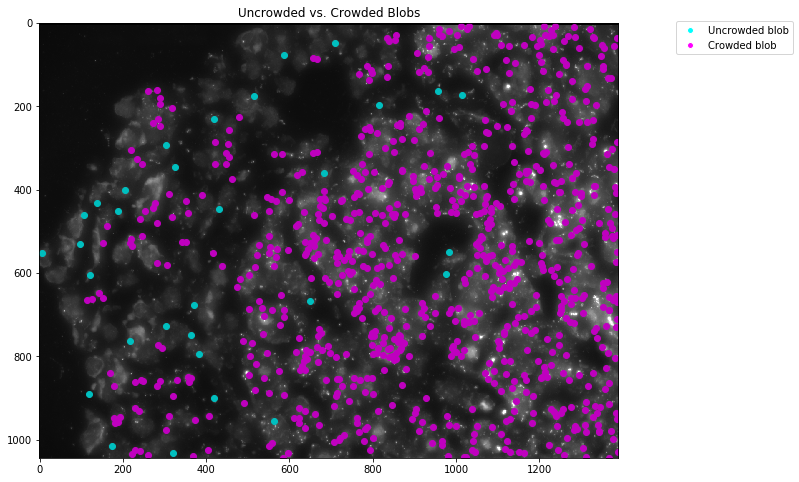

crowded blobs / total blobs = 191 / 251 = 0.760956


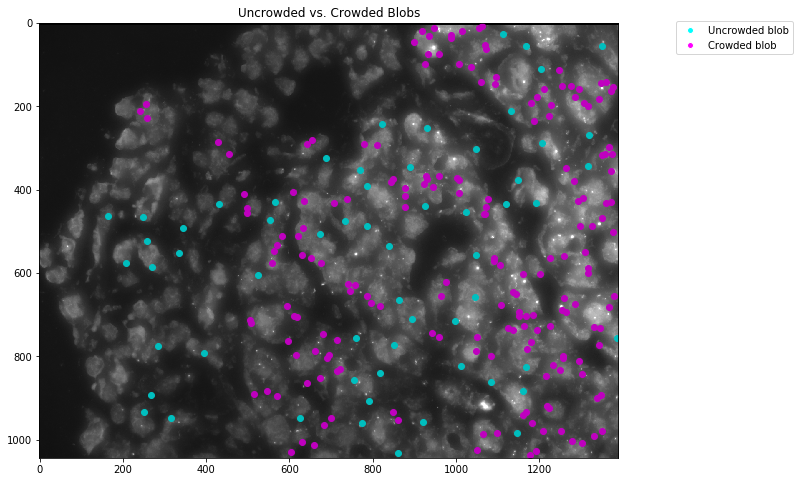

crowded blobs / total blobs = 105 / 160 = 0.656250


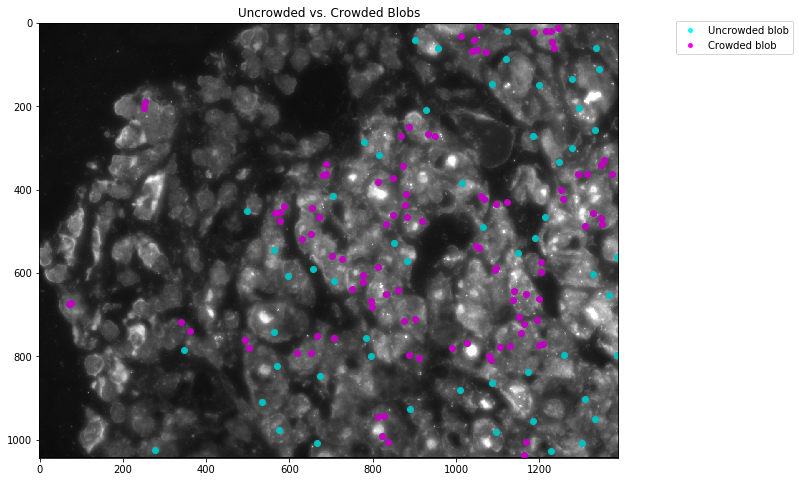

In [19]:
crowded_blobs_list = []
kdt_list = []
for blobs, img_path in zip(blobs_list, test_img_paths):
    kdt = KDTree(blobs, leaf_size=2, metric='euclidean')
    kdt_list.append(kdt)
    im = imread(img_path)
    img_width = len(im[0])
    
    crosshair_arm_length = crosshair_arm_to_image_width_ratio * img_width
    
    plt.figure(figsize = (12, 8))
    close_distances = []
    crowded_blobs = []
    for coord in blobs:
        nnd = get_nnd(coord, kdt)
        if nnd < crosshair_arm_length:
            close_distances.append(nnd)
            crowded_blobs.append(coord)
            plt.scatter(coord[0], coord[1], facecolors = 'm')
        else:
            plt.scatter(coord[0], coord[1], facecolors = 'c')
    crowded_blobs_list.append(crowded_blobs)

    s = 'crowded blobs / total blobs = %d / %d = %f' % (len(crowded_blobs), len(blobs), float(len(crowded_blobs))/len(blobs))
    print(s)
    
    plt.title('Uncrowded vs. Crowded Blobs')
    plt.imshow(im, cmap='gray')
    handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='cyan', label='Uncrowded blob'),
                  Line2D([0],[0], marker='o', color='w', markerfacecolor='magenta', label='Crowded blob')]
    plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.2, 1.015))
    plt.show()

## Step 2: Bound regions with many crowded spots.

Apply clustering or partitioning algorithm to crowded spots to separate out regions with many crowded spots.

## Hybrid approach: AffinityPropagation, then K-means

(This code block also collects all cluster members into `collect_cluster_members_lists`. Each element of `collect_cluster_members_lists` contains the lists of clusters and their members associated with one image.)

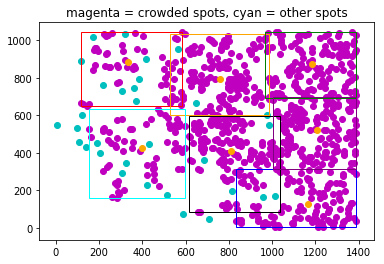

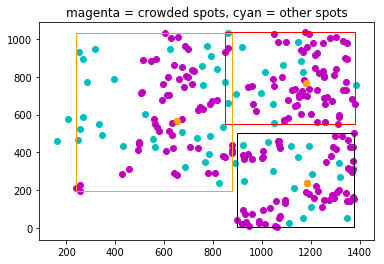

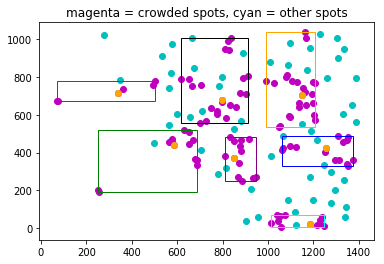

In [20]:
crop_bounds_list = []
for crowded_blobs, blobs, kdt in zip(crowded_blobs_list, blobs_list, kdt_list):
    
    # First try AffinityPropagaion, adjusting the preference parameter
    num_centers = max_num_crops + 1
    pref_param = -500
    crowded_coords = np.asarray(crowded_blobs)
    for _ in range(5):
        af = AffinityPropagation(preference = pref_param).fit(crowded_coords)
        centers = [crowded_coords[index] for index in af.cluster_centers_indices_]
        num_centers = len(centers)
        cluster_members_lists = [[] for i in range(len(centers))]
        for label_index, coord in zip(af.labels_, crowded_coords):
            cluster_members_lists[label_index].append(coord)
        pref_param *= 10
        if num_centers <= max_num_crops:
            break
    
    # If still too many clusters, partition using K-means
    if num_centers > max_num_crops:
        km = KMeans(n_clusters = max_num_crops).fit(crowded_coords)
        centers = km.cluster_centers_
        cluster_members_lists = [[] for i in range(len(centers))]
        for label_index, coord in zip(km.labels_, crowded_coords):
            cluster_members_lists[label_index].append(coord)
        
    crop_bounds = []
    for l in cluster_members_lists:
        l = np.asarray(l)
        x = l[:,0]
        y = l[:,1]
        crop_bounds.append((min(x), max(x), min(y), max(y)))
    
    crop_bounds_list.append(crop_bounds)
    
    fig,ax = plt.subplots(1)
    for coord in blobs:
        nnd = get_nnd(coord, kdt)
        if nnd < crosshair_arm_length:
            ax.scatter(coord[0], coord[1], facecolors = 'm')
        else:
            ax.scatter(coord[0], coord[1], facecolors = 'c')
    for center in centers:
        plt.scatter(center[0], center[1], facecolors = 'orange')

    for crop, col in zip(crop_bounds, colors):
        rect = Rectangle((crop[0], crop[2]), crop[1]-crop[0], crop[3]-crop[2], edgecolor = col, facecolor = 'none')
        ax.add_patch(rect)
    plt.title('magenta = crowded spots, cyan = other spots')
    plt.show()

# Go one level deeper: execute crowdedness detection and cropping on the clusters found above using the hybrid (AP + KM) approach.

## Create crops.
Wherever crops overlap, only one of the crops should contain the blobs in the overlap region.

In [21]:
crops_members_lists = []

# for each of the three test images
for crops_bounds, blobs in zip(crop_bounds_list, blobs_list):
    
    # designate a bin for all "used" blobs. the same blob should not end up in multiple different crops.
    used_blobs = []
    
    # lists of blobs that will be in each crop
    crops_members = []
    
    # for each crop
    for crop_bounds in crops_bounds:
        
        # list of blobs that will be in that crop
        crop_members = []
    
        # get bounds
        min_x, max_x, min_y, max_y = crop_bounds
                
        for blob in blobs:
            x, y = blob
            if x >= min_x and x <= max_x and y >= min_y and y <= max_y:
                if blob not in used_blobs:
                    crop_members.append(blob)
                    used_blobs.append(blob)
                
        crops_members.append(crop_members)
    
    crops_members_lists.append(crops_members)

## Generate crops from the parent images, visualize.

Wherever crops overlap,  one of the crops should have the overlap region blacked out.

bb = x_min, x_max, y_min, y_max = col_min, col_max, row_min, row_max

In [22]:
crosshair_ratio = 0.03045

In [23]:
def get_crop(parent_im, bb):
    return parent_im[int(bb[2]) : int(bb[3]), int(bb[0]) : int(bb[1])]

-------------------------- ISS_rnd0_ch1_z0 --------------------------
------------------ Crop #0 ------------------


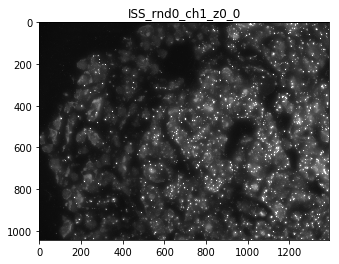

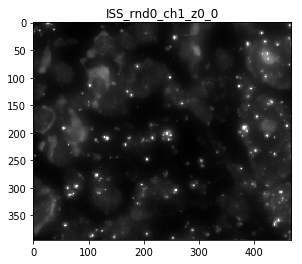

crowded blobs / total blobs = 22 / 66 = 0.333333


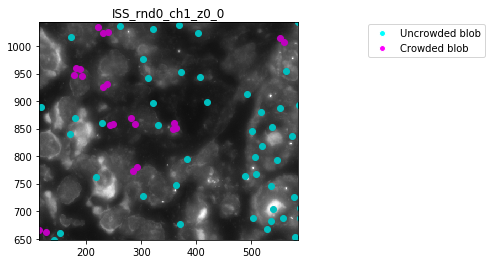

------------------ Crop #1 ------------------


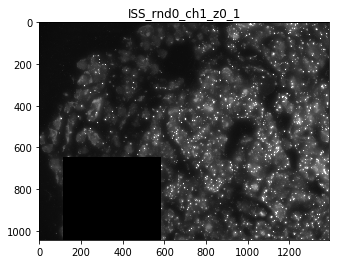

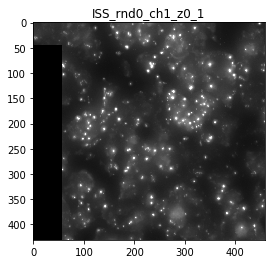

crowded blobs / total blobs = 74 / 143 = 0.517483


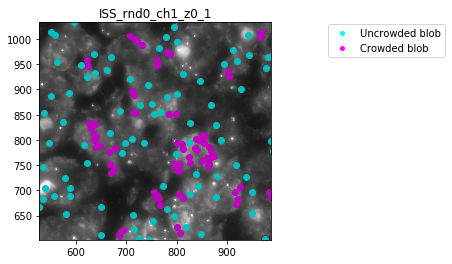

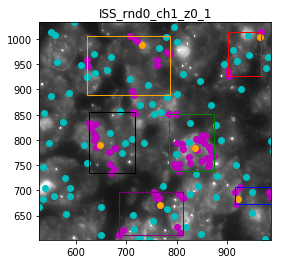

------------------ Crop #2 ------------------


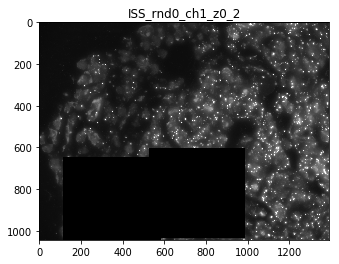

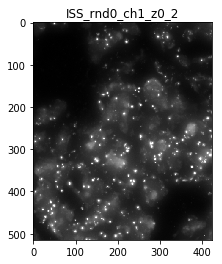

crowded blobs / total blobs = 84 / 159 = 0.528302


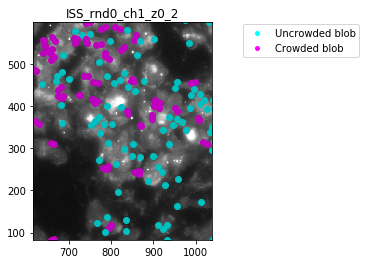

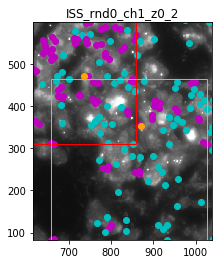

------------------ Crop #3 ------------------


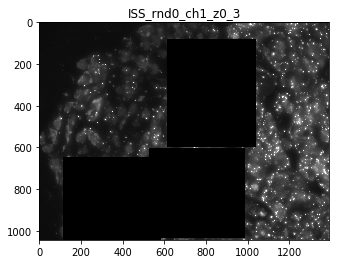

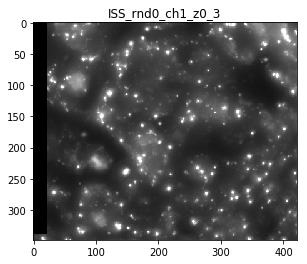

crowded blobs / total blobs = 40 / 134 = 0.298507


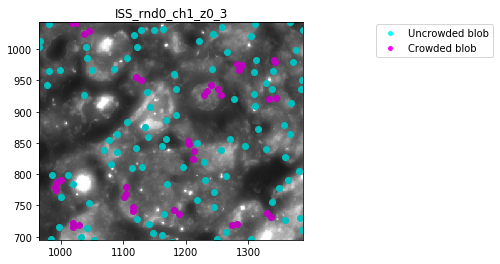

------------------ Crop #4 ------------------


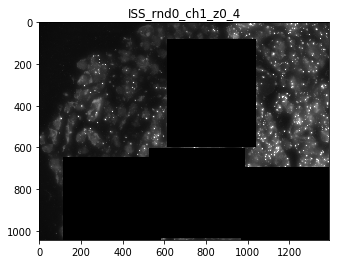

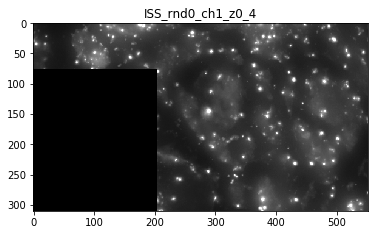

crowded blobs / total blobs = 58 / 110 = 0.527273


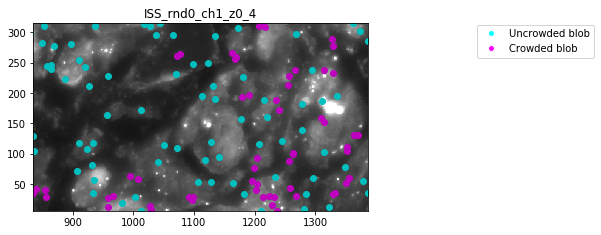

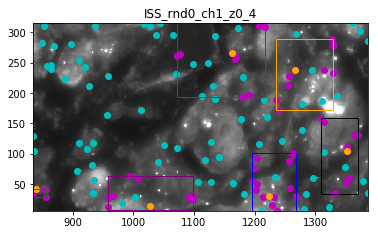

------------------ Crop #5 ------------------


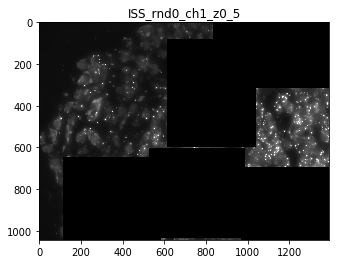

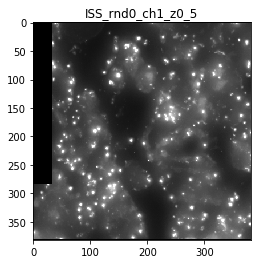

crowded blobs / total blobs = 78 / 155 = 0.503226


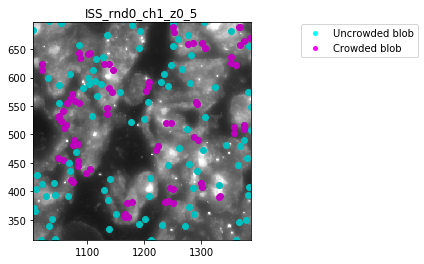

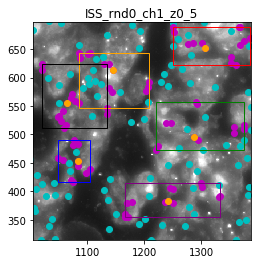

------------------ Crop #6 ------------------


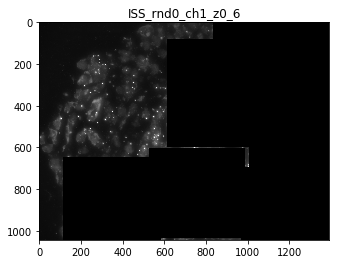

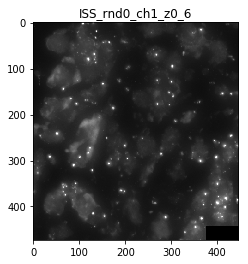

crowded blobs / total blobs = 13 / 71 = 0.183099


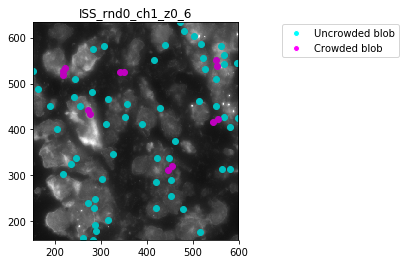

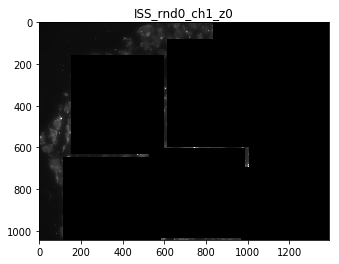

-------------------------- ISS_rnd0_ch3_z0 --------------------------
------------------ Crop #0 ------------------


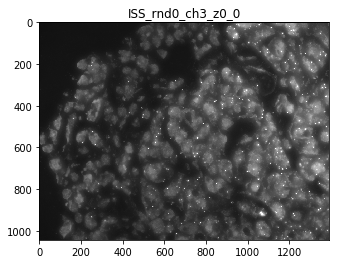

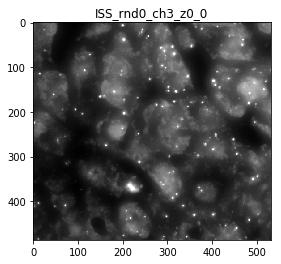

crowded blobs / total blobs = 25 / 80 = 0.312500


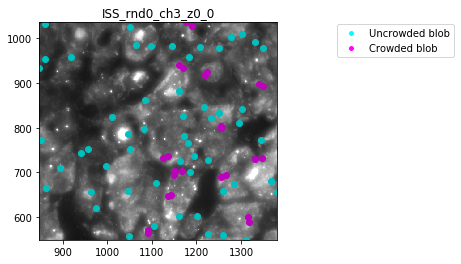

------------------ Crop #1 ------------------


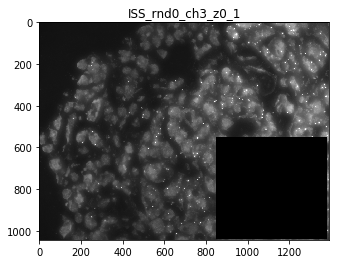

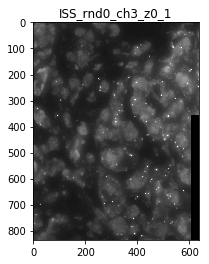

crowded blobs / total blobs = 23 / 88 = 0.261364


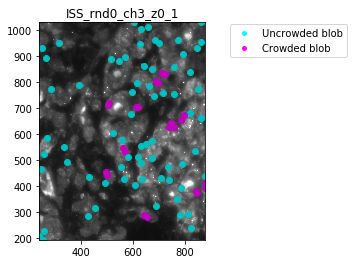

------------------ Crop #2 ------------------


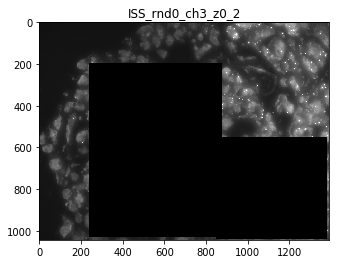

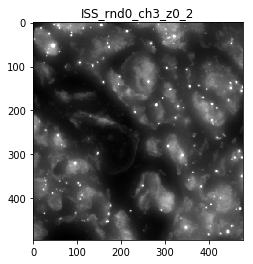

crowded blobs / total blobs = 25 / 79 = 0.316456


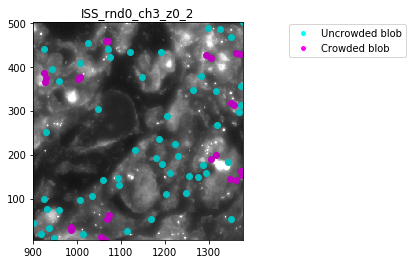

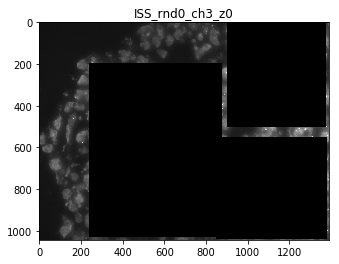

-------------------------- ISS_rnd1_ch1_z0 --------------------------
------------------ Crop #0 ------------------


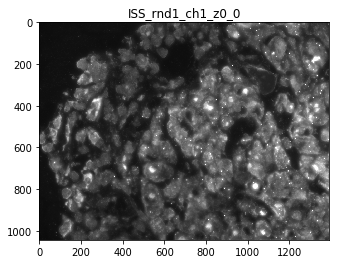

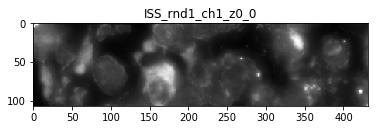

crowded blobs / total blobs = 2 / 6 = 0.333333


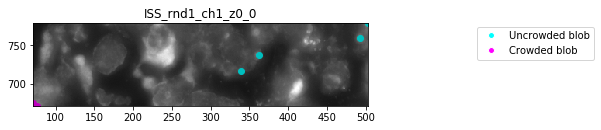

------------------ Crop #1 ------------------


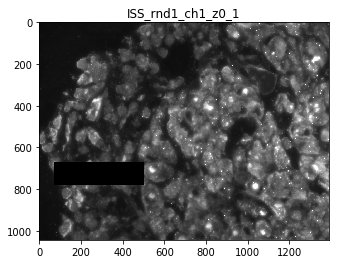

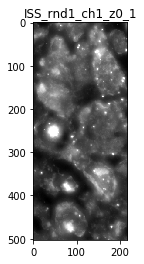

crowded blobs / total blobs = 2 / 30 = 0.066667


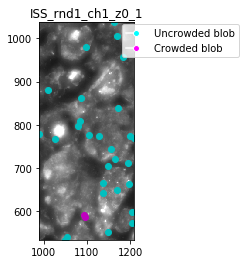

------------------ Crop #2 ------------------


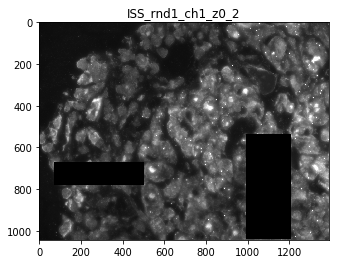

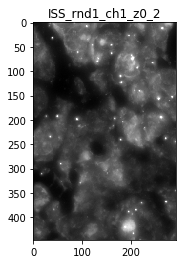

crowded blobs / total blobs = 0 / 29 = 0.000000


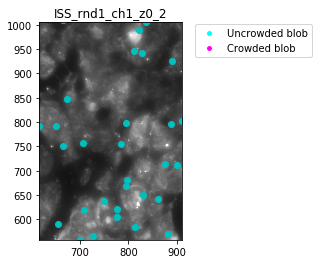

------------------ Crop #3 ------------------


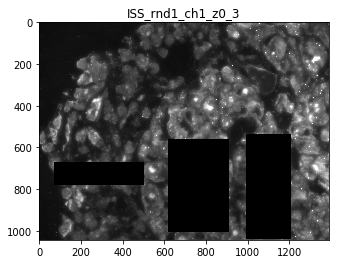

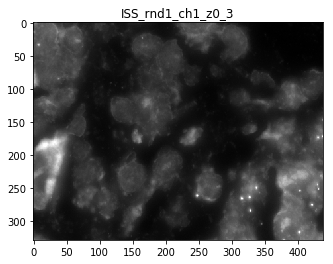

crowded blobs / total blobs = 4 / 14 = 0.285714


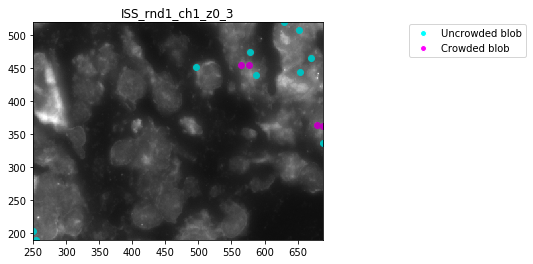

------------------ Crop #4 ------------------


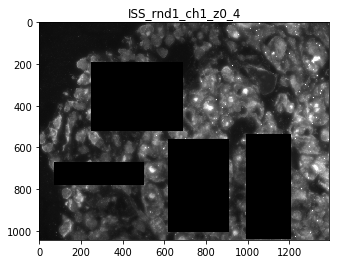

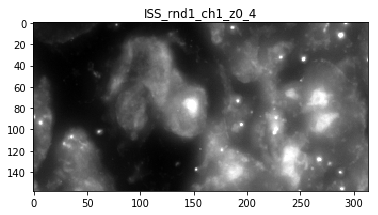

crowded blobs / total blobs = 2 / 17 = 0.117647


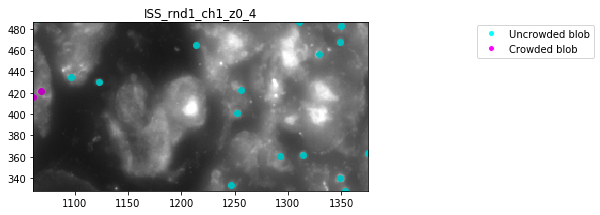

------------------ Crop #5 ------------------


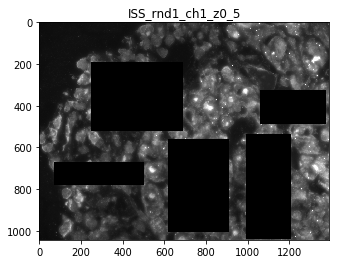

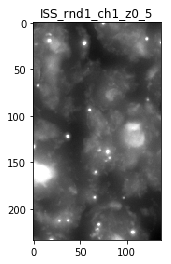

crowded blobs / total blobs = 0 / 14 = 0.000000


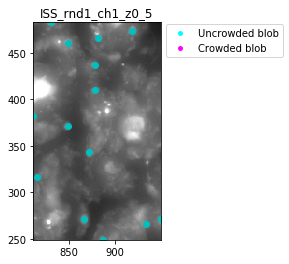

------------------ Crop #6 ------------------


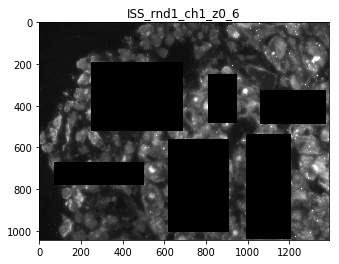

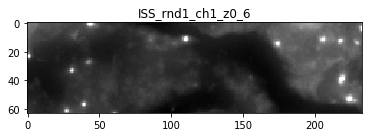

crowded blobs / total blobs = 0 / 13 = 0.000000


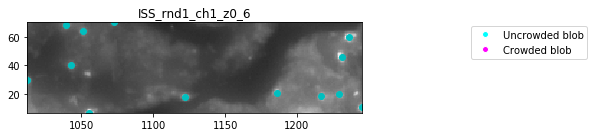

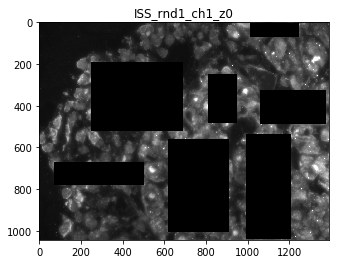

In [24]:
# for each of the three test images
for crops_bounds, blobs, img_path, img_name, crops_members in zip(crop_bounds_list, blobs_list, test_img_paths, test_img_filenames, crops_members_lists):
    
    print('-------------------------- %s --------------------------' % img_name)
    parent_im = imread(img_path)
    
    for crop_index in range(len(crops_bounds)):
        print('------------------ Crop #%d ------------------' % crop_index)
        crop_bounds = crops_bounds[crop_index]
        
        crop = get_crop(parent_im, crop_bounds)
        
        new_img_name = img_name + '_' + str(crop_index)
        plt.imsave(new_img_name + '.png', crop, cmap='gray')
        np.savetxt(new_img_name + '.csv', [x for x in crop_bounds], delimiter=",", comments='')

        plt.figure()
        plt.imshow(parent_im, cmap='gray')
        plt.title('Minus %s' % new_img_name)
        plt.show()
        
        plt.figure()
        plt.imshow(crop, cmap='gray')
        plt.title(new_img_name)
        plt.show()

        for r in range(parent_im.shape[0]):
            for c in range(parent_im.shape[1]):
                if (r >= crop_bounds[2]) and (r <= crop_bounds[3]):
                    if (c >= crop_bounds[0]) and (c <= crop_bounds[1]):
                        parent_im[r][c] = 0
        
        # See what blobs in the crops are still crowded
        
        crop_members = crops_members[crop_index]
        crop_bounds = crops_bounds[crop_index]
        new_crosshair_arm_length = (crop_bounds[1] - crop_bounds[0]) * crosshair_ratio

        kdt = KDTree(crop_members, leaf_size=2, metric='euclidean')
        plt.figure()
        crowded_blobs = []
        for coord in blobs:
            nnd = get_nnd(coord, kdt)
            if nnd < new_crosshair_arm_length:
                crowded_blobs.append(coord)
                plt.scatter(coord[0], coord[1], facecolors = 'm')
            else:
                plt.scatter(coord[0], coord[1], facecolors = 'c')

        s = 'crowded blobs / total blobs = %d / %d = %f' % (len(crowded_blobs), len(crop_members), float(len(crowded_blobs))/len(crop_members))
        print(s)

        plt.title(new_img_name)
        plt.imshow(im, cmap='gray')
        handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='cyan', label='Uncrowded blob'),
                      Line2D([0],[0], marker='o', color='w', markerfacecolor='magenta', label='Crowded blob')]
        plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.5, 1.015))
        plt.xlim(crop_bounds[0], crop_bounds[1])
        plt.ylim(crop_bounds[2], crop_bounds[3])
        plt.show()
        
#         # if the crop is still too crowded
#         if float(len(crowded_blobs))/len(crop_members) > 0.4:
            
#             new_parent = im
            
#             edge_0, edge_1, edge_2, edge_3 = crop_bounds[0], crop_bounds[1], crop_bounds[2], crop_bounds[3]

#             # First try AffinityPropagaion, adjusting the preference parameter
#             num_centers = max_num_crops + 1
#             pref_param = -500
#             crowded_coords = np.asarray(crowded_blobs)
#             for _ in range(5):
#                 af = AffinityPropagation(preference = pref_param).fit(crowded_coords)
#                 centers = [crowded_coords[index] for index in af.cluster_centers_indices_]
#                 num_centers = len(centers)
#                 cluster_members_lists = [[] for i in range(len(centers))]
#                 for label_index, coord in zip(af.labels_, crowded_coords):
#                     cluster_members_lists[label_index].append(coord)
#                 pref_param *= 10
#                 if num_centers <= max_num_crops:
#                     break

#             # If still too many clusters, partition using K-means
#             if num_centers > max_num_crops:
#                 km = KMeans(n_clusters = max_num_crops).fit(crowded_coords)
#                 centers = km.cluster_centers_
#                 cluster_members_lists = [[] for i in range(len(centers))]
#                 for label_index, coord in zip(km.labels_, crowded_coords):
#                     cluster_members_lists[label_index].append(coord)

#             crop_bounds = []
#             for l in cluster_members_lists:
#                 l = np.asarray(l)
#                 x = l[:,0]
#                 y = l[:,1]
#                 crop_bounds.append((min(x), max(x), min(y), max(y)))

#             fig,ax = plt.subplots(1)
#             for coord in blobs:
#                 nnd = get_nnd(coord, kdt)
#                 if nnd < new_crosshair_arm_length:
#                     ax.scatter(coord[0], coord[1], facecolors = 'm')
#                 else:
#                     ax.scatter(coord[0], coord[1], facecolors = 'c')
#             for center in centers:
#                 plt.scatter(center[0], center[1], facecolors = 'orange')

#             for crop, col in zip(crop_bounds, colors):
#                 rect = Rectangle((crop[0], crop[2]), crop[1]-crop[0], crop[3]-crop[2], edgecolor = col, facecolor = 'none')
#                 ax.add_patch(rect)
#             plt.title(new_img_name)
#             plt.imshow(im, cmap='gray')
#             plt.xlim(edge_0, edge_1)
#             plt.ylim(edge_2, edge_3)
#             plt.show()
            
#             # crop in again
            
#             for crop_ind in range(len(crop_bounds)):
                
#                 print('------------------ Crop #%d.%d ------------------' % (crop_index, crop_ind))
            
#                 bounds = crop_bounds[crop_ind]
#                 new_crop = new_parent[int(bounds[2]) : int(bounds[3]), int(bounds[0]) : int(bounds[1])]

#                 new_new_img_name = img_name + '_' + str(crop_ind)
#                 plt.imsave(new_new_img_name + '.png', new_crop, cmap='gray')
#                 np.savetxt(new_new_img_name + '.csv', [x for x in crop_bounds], delimiter=",", comments='')

#                 plt.figure()
#                 plt.imshow(new_parent, cmap='gray')
#                 plt.title(new_new_img_name)
#                 plt.show()

#                 plt.figure()
#                 plt.imshow(new_crop, cmap='gray')
#                 plt.title(new_new_img_name)
#                 plt.show()

#                 for r in range(new_parent.shape[0]):
#                     for c in range(new_parent.shape[1]):
#                         if (r >= bounds[2]) and (r <= bounds[3]):
#                             if (c >= bounds[0]) and (c <= bounds[1]):
#                                 new_parent[r][c] = 0

#                 # See what blobs in the crops are still crowded

#                 crop_members = crops_members[crop_ind]
#                 new_crosshair_arm_length = (bounds[1] - bounds[0]) * crosshair_ratio

#                 kdt = KDTree(crop_members, leaf_size=2, metric='euclidean')
#                 plt.figure()
#                 crowded_blobs = []
#                 for coord in blobs:
#                     nnd = get_nnd(coord, kdt)
#                     if nnd < new_crosshair_arm_length:
#                         crowded_blobs.append(coord)
#                         plt.scatter(coord[0], coord[1], facecolors = 'm')
#                     else:
#                         plt.scatter(coord[0], coord[1], facecolors = 'c')

#                 s = 'crowded blobs / total blobs = %d / %d = %f' % (len(crowded_blobs), len(crop_members), float(len(crowded_blobs))/len(crop_members))
#                 print(s)

#                 plt.title(new_new_img_name)
#                 plt.imshow(im, cmap='gray')
#                 handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='cyan', label='Uncrowded blob'),
#                               Line2D([0],[0], marker='o', color='w', markerfacecolor='magenta', label='Crowded blob')]
#                 plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.5, 1.015))
#                 plt.xlim(bounds[0], bounds[1])
#                 plt.ylim(bounds[2], bounds[3])
#                 plt.show()
              
    plt.figure()
    plt.imshow(parent_im, cmap='gray')
    plt.title(img_name)
    plt.show()

